<a href="https://colab.research.google.com/github/aryan-cs/poker-like-games/blob/discrete-poker/simulations_and_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exhaustive Simulations

To begin understanding the Poker Model, we start by simulating every possible cutoff matchup for an arbitrary case of $n$. Due to the increase in computational power Python offers, we are no longer limited to the case $n = 3$, and can thus increase $n$ to values such as $n = 100$, where we begin to see asympototic behavior resemblant of the original, continuous Poker model.

## Helper Functions

In [175]:
from fractions import Fraction

P1, P2 = True, True
RED = "#ff2684"
BLUE = "#19beff"
WHITE = "#ebebeb"
GRAY = "#858585"

def decimal_to_fraction(decimal, max_denominator=10):
  if decimal == 0: return 0
  fraction = Fraction(decimal).limit_denominator(max_denominator)
  return f"{fraction.numerator}/{fraction.denominator}"

def boxed(text):
  lines = text.splitlines()
  if lines and lines[0] == "": lines = lines[1:]
  if not lines: return

  max_width = max(map(len, lines))

  print("┌" + "─" * (max_width + 2) + "┐")
  for line in lines:
    print(f"│ {line.ljust(max_width)} │")
  print("└" + "─" * (max_width + 2) + "┘")

def number_of_possible_hands_with(n):
  return n * (n - 1)

cache = []

def memoize(kA, kB, EA, EB, verbose=True):
  cache.append({
      'kA': kA,
      'kB': kB,
      'EA': EA,
      'EB': EB,
  })

  if verbose:
    message = '''
(kA, kB): ({0}, {1})
(EA, EB): ({2}, {3})
'''.format(kA,
          kB,
          decimal_to_fraction(EA),
          decimal_to_fraction(EB))
    boxed(message)

def save():
    df = pd.DataFrame(cache)
    df.to_csv('data.csv', index=False)

## Calculating Payouts

Terminology & Naming  
```kA``` = $k_A$  
```kB``` = $k_B$  
```EA``` = $\mathbb{E}_A(k_A)$  
```EB``` = $\mathbb{E}_B(k_B)$

In [216]:
#@title { vertical-output: true }

import time

def test_cutoffs(kA, kB):
  start_time = time.time()

  global EA
  global EB

  EA = 0
  EB = 0

  # Testing every possible 'card' for Player A and Player B
  for cA in range(1, n + 1):
    for cB in range(1, n + 1):

      if cA == cB: continue

      # Player A in betting region, Player B in betting region
      if cA >= kA and cB >= kB:

        # Case BBW
        if cA > cB:       # Player A wins showdown
          EA += 2
          EB -= 2

        # Case BBL
        else:                       # Player B wins showdown
          EA -= 2
          EB += 2

      # Player A in folding region, Player B in folding region
      elif cA < kA and cB < kB:

        # Case FFW
        if cA > cB:       # Player A wins showdown
          EA += 1
          EB -= 1

        # Case FFL
        else:                       # Player B wins showdown
          EA -= 1
          EB += 1

      # Player A in betting region, Player B in folding region | Player B forfeits, Player A wins by default
      elif cA >= kA and cB < kB:

        # Case BFW
        EA += 1
        EB -= 1

      # Player A in folding region, Player B in betting region | Player A forfeits, Player B wins by default
      elif cB >= kB and cA < kA:

        # Case FBL
        EA -= 1
        EB += 1
  return EA, EB

start_time = time.time()
cache = []
n = 3
trials = number_of_possible_hands_with(n)

for kA in range(1, n + 1):
  for kB in range(1, n + 1):
     #NOTE: If graphing level curves, fix either kA or kB
    # EA, EB = test_cutoffs(kA, 10)
    EA, EB = test_cutoffs(kA, kB)
    memoize(kA, kB,
            EA / trials,
            EB / trials)

save()

boxed(f"Executed all iterations in {round(time.time() - start_time, 5)} seconds.\n")

┌──────────────────┐
│ (kA, kB): (1, 1) │
│ (EA, EB): (0, 0) │
└──────────────────┘
┌───────────────────────┐
│ (kA, kB): (1, 2)      │
│ (EA, EB): (-1/3, 1/3) │
└───────────────────────┘
┌──────────────────┐
│ (kA, kB): (1, 3) │
│ (EA, EB): (0, 0) │
└──────────────────┘
┌───────────────────────┐
│ (kA, kB): (2, 1)      │
│ (EA, EB): (1/3, -1/3) │
└───────────────────────┘
┌──────────────────┐
│ (kA, kB): (2, 2) │
│ (EA, EB): (0, 0) │
└──────────────────┘
┌───────────────────────┐
│ (kA, kB): (2, 3)      │
│ (EA, EB): (-1/6, 1/6) │
└───────────────────────┘
┌──────────────────┐
│ (kA, kB): (3, 1) │
│ (EA, EB): (0, 0) │
└──────────────────┘
┌───────────────────────┐
│ (kA, kB): (3, 2)      │
│ (EA, EB): (1/6, -1/6) │
└───────────────────────┘
┌──────────────────┐
│ (kA, kB): (3, 3) │
│ (EA, EB): (0, 0) │
└──────────────────┘
┌─────────────────────────────────────────────┐
│ Executed all iterations in 0.02102 seconds. │
└─────────────────────────────────────────────┘


# Visualizing Expected Payout

To gain some intuition for the relationship between a player's strategy and their expected payout, we can graph the expectation as a function of cutoff and analyze the changes in the function.

## 3D Contour Plot

In [192]:
#@title { vertical-output: true }

import pandas as pd
import plotly.graph_objects as go
import numpy as np

def contour_plot(p1=False, p2=False):
    df = pd.DataFrame(cache).groupby(['kA', 'kB'], as_index=False).mean()
    fig = go.Figure()

    x = np.unique(df['kA'])
    y = np.unique(df['kB'])
    X, Y = np.meshgrid(x, y)

    if p1:
        Z1 = df.pivot_table(
            index='kB',
            columns='kA',
            values='EA').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z1,
                                 colorscale='Blues',
                                 opacity=0.9,
                                 name="Player A",
                                 showscale=False))

    if p2:
        Z2 = df.pivot_table(
            index='kB',
            columns='kA',
            values='EB').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z2,
                                 colorscale='Reds',
                                 opacity=0.9,
                                 name="Player B",
                                 showscale=False))

    fig.update_layout(
        scene=dict(
            xaxis_title='kA',
            yaxis_title='kB',
            zaxis_title='E'
        ),
        showlegend=False
    )

    fig.show()

contour_plot(p1=True, p2=False)

## 3D Lattice

In [193]:
#@title { vertical-output: true }

import pandas as pd
import plotly.graph_objects as go
import numpy as np

def lattice(p1=False, p2=False):
    df = pd.DataFrame(cache)
    fig = go.Figure()

    if p1:
        fig.add_trace(go.Scatter3d(
            x=df['kA'],
            y=df['kB'],
            z=df['EA'],
            mode='markers',
            marker=dict(
                size=4,
                color=df['EA'],
                colorscale='Blues',
                showscale=False,
            ),
            name='Player A'
        ))

    if p2:
        fig.add_trace(go.Scatter3d(
            x=df['kA'],
            y=df['kB'],
            z=df['EB'],
            mode='markers',
            marker=dict(
                size=4,
                color=df['EA'],
                colorscale='Reds',
                showscale=False,
            ),
            name='Player B'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='kA',
            yaxis_title='kB',
            zaxis_title='E'
        ),
        showlegend=False
    )

    fig.show()

lattice(p1=True, p2=False)

## 2D Level Curve

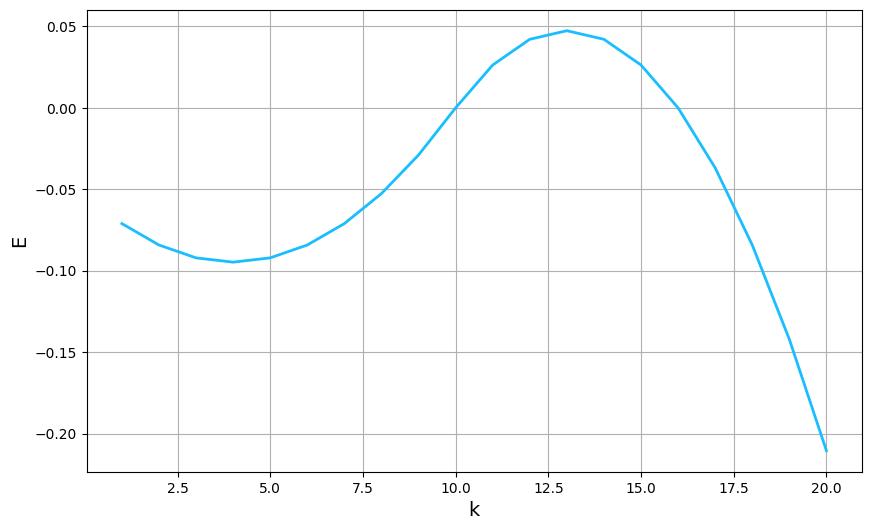

In [213]:
#@title { vertical-output: true }

import matplotlib.pyplot as plt

def level_curve(p1=False, p2=False):
    df = pd.DataFrame(cache).groupby(['kA', 'kB'], as_index=False).mean()

    plt.figure(figsize=(10, 6))

    if p1: plt.plot(df['kA'],
                    df['EA'],
                    label='Player 1',
                    color=BLUE,
                    linewidth=2)
    elif p2: plt.plot(df['kA'],
                    df['EB'],
                    label='Player 2',
                    color=RED,
                    linewidth=2);

    plt.xlabel('k', fontsize=14)
    plt.ylabel('E', fontsize=14)

    plt.grid(True)
    plt.show()

level_curve(p1=True, p2=False)

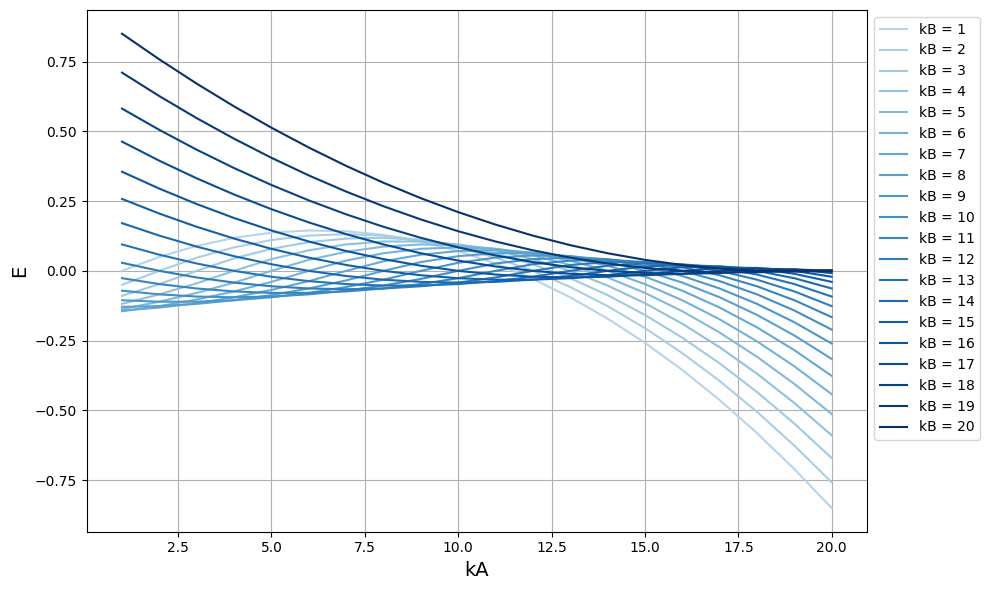

In [215]:
#@title { vertical-output: true }

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def level_curves(p1=False, p2=False):
    df = pd.DataFrame(cache).groupby(['kA', 'kB'], as_index=False).mean()
    n = df['kA'].nunique()

    plt.figure(figsize=(10, 6))

    if p1:
        colors = cm.Blues(np.linspace(0.3, 1, n))
        for kB_val in df['kB'].unique():
            subset = df[df['kB'] == kB_val]
            plt.plot(subset['kA'], subset['EA'],
                     color=colors[kB_val-1],
                     label=f'kB = {kB_val}')
        plt.xlabel('kA', fontsize=14)

    if p2:
        colors = cm.Reds(np.linspace(0.3, 1, n))
        for kA_val in df['kA'].unique():
            subset = df[df['kA'] == kA_val]
            plt.plot(subset['kB'], subset['EB'],
                     color=colors[kA_val-1],
                     label=f'kA = {kA_val}')
        plt.xlabel('kB', fontsize=14)

    plt.ylabel('E', fontsize=14)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

level_curves(p1=True, p2=False)